# Part 3, Topic 1: AES256 Bootloader Attack (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *When we attacked that AES256 bootloader, we had a lot of knowledge going in. Depending on the situation, more knowledge than we should've had. In part B of this lab, we'll take a look at how you could approach that lab with a lot more unknowns and figure things out yourself by looking at power traces.*

**LEARNING OUTCOMES:**

* Understanding how AES can be optimized on 32-bit platforms.
* Attacking an optimized version of AES using CPA

Things unassumed:

* Device is using AES256
    * We figure this out by looking at the power trace of the encryption
* Trigger goes high before encryption
    * We trigger off our IO pin instead
* AES in CBC mode
    * Figured out by looking at the start and end of the encryption
* Device has a signature
    * Guess and check

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'

In [2]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

Serial baud rate = 38400
INFO: Found ChipWhisperer😍


In [3]:
fw_path = "../../../hardware/victims/firmware/bootloader-aes256/bootloader-aes256-{}.hex".format(PLATFORM)
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5863 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5863 bytes
Serial baud rate = 38400


## The Situation

Simply put, we've got a target device running an encrypted bootloader (a program used to upload new code onto a device) and we want to see if we can get our own code running on the device. We've done a bit of sniffing on the serial lines when the device's firmware is being updated and we've learned the following:

* The device communicates over serial at 38400 baud
* When writing memory, the first byte is always zero (probably a command byte)
* There's a 16 byte block of random looking memory (aka it doesn't look like firmware). This part is probably encrypted
* There's a 4 byte CRC at the end of each message

All together this looks like:

```
       |<-------- Encrypted block (16 bytes) ---------->|
       |                                                |
+------+------+------+------+------+------+ .... +------+------+------+
| 0x00 |              Random looking data               |   CRC-16    |
+------+------+------+------+------+------+ .... +------+------+------+
```

This time, we won't be triggering off of our trigger pins (you can remove them from the code if you'd like).

## Doing Recon

Our first step will be to see if we can learning anything about the bootloader from looking at its power traces. Let's start with the boot sequence:

In [4]:
scope.trigger.triggers = "nrst"

In [5]:
scope.adc.samples = 24400

In [6]:
scope.arm()
reset_target(scope)
scope.capture()
wave = scope.get_last_trace()

<IPython.core.display.Javascript object>


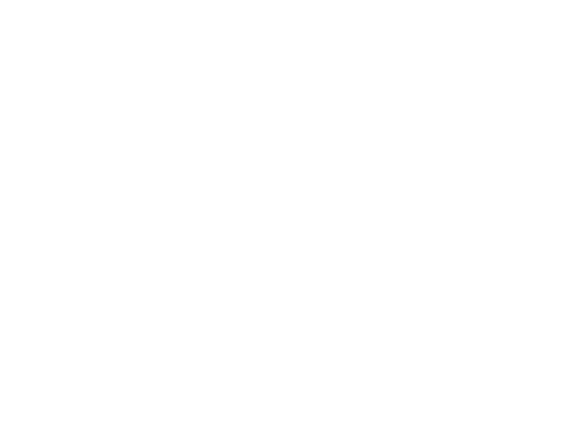

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(wave)
plt.show()

The device does appear to be doing something, but it's clearly nothing major - no encryptions or anything. Probably, it's just moving some memory around and doing setup. Let's move onto the messages themselves:

In [8]:
target = cw.target(scope)

Serial baud rate = 38400


In [9]:
# Class Crc
#############################################################
# These CRC routines are copy-pasted from pycrc, which are:
# Copyright (c) 2006-2013 Thomas Pircher <tehpeh@gmx.net>
#
class Crc(object):
    """
    A base class for CRC routines.
    """

    def __init__(self, width, poly):
        """The Crc constructor.

        The parameters are as follows:
            width
            poly
            reflect_in
            xor_in
            reflect_out
            xor_out
        """
        self.Width = width
        self.Poly = poly


        self.MSB_Mask = 0x1 << (self.Width - 1)
        self.Mask = ((self.MSB_Mask - 1) << 1) | 1

        self.XorIn = 0x0000
        self.XorOut = 0x0000

        self.DirectInit = self.XorIn
        self.NonDirectInit = self.__get_nondirect_init(self.XorIn)
        if self.Width < 8:
            self.CrcShift = 8 - self.Width
        else:
            self.CrcShift = 0

    def __get_nondirect_init(self, init):
        """
        return the non-direct init if the direct algorithm has been selected.
        """
        crc = init
        for i in range(self.Width):
            bit = crc & 0x01
            if bit:
                crc ^= self.Poly
            crc >>= 1
            if bit:
                crc |= self.MSB_Mask
        return crc & self.Mask


    def bit_by_bit(self, in_data):
        """
        Classic simple and slow CRC implementation.  This function iterates bit
        by bit over the augmented input message and returns the calculated CRC
        value at the end.
        """
        # If the input data is a string, convert to bytes.
        if isinstance(in_data, str):
            in_data = [ord(c) for c in in_data]

        register = self.NonDirectInit
        for octet in in_data:
            for i in range(8):
                topbit = register & self.MSB_Mask
                register = ((register << 1) & self.Mask) | ((octet >> (7 - i)) & 0x01)
                if topbit:
                    register ^= self.Poly

        for i in range(self.Width):
            topbit = register & self.MSB_Mask
            register = ((register << 1) & self.Mask)
            if topbit:
                register ^= self.Poly

        return register ^ self.XorOut
    
bl_crc = Crc(width = 16, poly=0x1021)

In [10]:
scope.trigger.triggers = "tio2"
scope.adc.samples = 24400
scope.adc.decimate = 1
def cap_trace(enc_block):
    message = [0x00]
    target.read()

    key, text = ktp.next()
    message.extend(enc_block)

    crc = bl_crc.bit_by_bit(enc_block)
    message.append(crc >> 8)
    message.append(crc & 0xFF)

    

    target.write(message[:-1])
    time.sleep(0.01)
    scope.arm()
    target.write([crc&0xFF])
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')
    response = target.read()
    if ord(response[0]) != 0xA4:
        # Bad response, just skip
        print("Bad response: {:02X}".format(ord(response[0])))

    return scope.get_last_trace()
    
ktp = cw.ktp.Basic()
text, key = ktp.next()
wave = cap_trace(text)
wave2 = cap_trace(text)

<IPython.core.display.Javascript object>


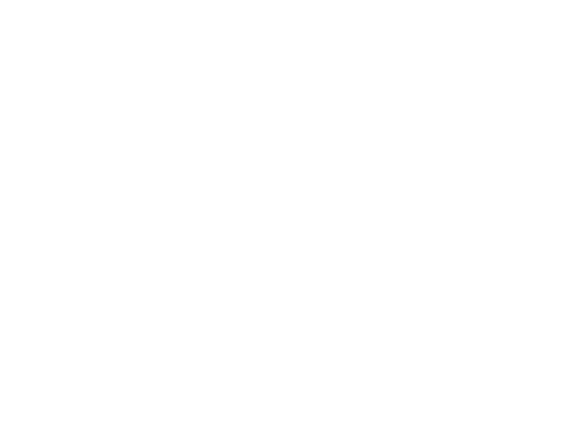

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(wave)
plt.plot(wave2)
plt.show()

We've found the decryption. Some things to notice from this:

1. The target immediately goes from reading the ciphertext to running a decryption - there's no preprocessing done at all. This means the ciphertext is likely being immediately fed into the decryption algorithm.
1. It looks like it's got the familiar shape of AES - this looks a lot like the TINYAES128 implementation
1. We can't see the full encryption
1. There's some jitter here. We'll probably have to resync the traces if we run a CPA attack

Since we can't see the full encryption, decimate the ADC (we don't care too much about the fine details here) and take another look...


## The full encryption

You should see that there isn't 10 rounds like we'd expect out of AES128 - there's 14! AES256, which uses a 32 byte key, uses 14 rounds for its encryption instead of 16. This isn't really a big deal for our attack, we just need to make a small extension onto it and we can recover the full key.

The knowledge we've gained so far, that the ciphertext is being decrypted and that the target is running AES256, is actually enough info to recover the key! All that's left is to do our standard capture loop and run a CPA attack. Don't forget to set the ADC decimation back to 1 if you've changed it.

In [27]:
from tqdm.notebook import trange
project = cw.create_project("projects/Tutorial_A5", overwrite=True)
scope.adc.offset = 4000
for i in trange(200):
    ktp = cw.ktp.Basic()
    key, text = ktp.next()
    wave = cap_trace(text)
    trace = cw.Trace(wave, text, bytearray([0]*16), bytearray([0]*16))
    project.traces.append(trace)

<IPython.core.display.Javascript object>


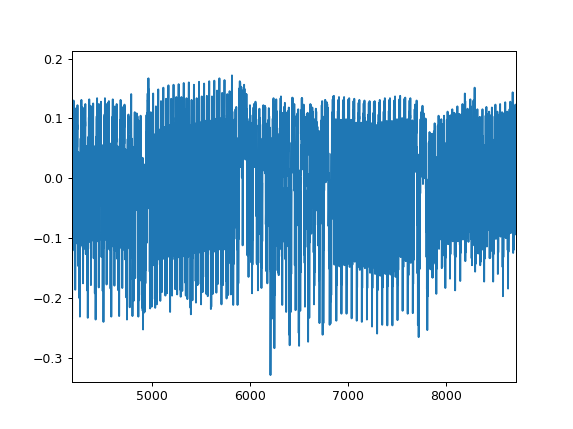

In [29]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(project.waves[0])
#plt.plot(project.waves[1])
plt.show()

In [31]:
import chipwhisperer as cw
import chipwhisperer.analyzer as cwa

leak_model = cwa.leakage_models.inverse_sbox_output
resync = cwa.preprocessing.ResyncSAD(project)
resync.enabled=True
resync.ref_trace = 0
resync.target_window = (4500, 7500)
resync.max_shift = 4500
new_proj = resync.preprocess()



<IPython.core.display.Javascript object>


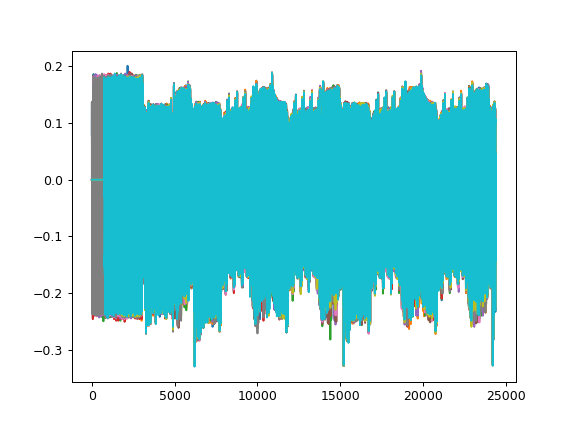

In [32]:
%matplotlib notebook
plt.figure()
for i in range(10):
    plt.plot(new_proj.waves[i])
    
plt.show()

In [15]:
new_proj.waves[0]

array([ 0.01074219, -0.21972656, -0.08300781, ...,  0.07324219,
        0.10839844,  0.10351562])

In [33]:
attack = cwa.cpa(new_proj, leak_model)
attack.pont_range = [3000, 10000]

#key = [0xea, 0x79, 0x79, 0x20, 0xc8, 0x71, 0x44, 0x7d, 0x46, 0x62, 0x5f, 0x51, 0x85, 0xc1, 0x3b, 0xcb]

cb = cwa.get_jupyter_callback(attack)
attack_results = attack.run(cb)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
PGE=,208,22,69,34,201,129,173,161,187,166,251,41,96,164,132,197
0,EA0.763,790.694,790.759,200.639,C80.747,710.763,440.706,7D0.826,460.668,620.783,5F0.742,510.735,850.641,C10.678,3B0.726,CB0.728
1,C10.393,9F0.361,810.366,0B0.389,650.348,F20.328,570.328,A80.356,080.331,540.366,080.344,810.405,740.325,630.354,A00.377,7C0.343
2,D70.350,290.350,770.355,980.339,E00.336,A60.327,950.327,8B0.353,880.330,DB0.350,E70.340,7D0.356,500.323,5C0.333,A90.344,4B0.336
3,640.336,490.346,C00.355,060.324,C50.333,8A0.324,100.326,160.334,190.328,5D0.331,470.332,0D0.348,CE0.321,500.333,C80.338,5D0.327
4,1B0.330,D30.344,400.347,E10.324,210.331,9E0.321,D90.318,F20.326,FC0.326,810.330,840.331,990.339,540.321,9D0.325,830.333,F40.325


In [34]:
calc_round_key = attack_results.key_guess()

In [35]:
import chipwhisperer as cw

class AES256_Round13_Model(cwa.AESLeakageHelper):
    def leakage(self, pt, ct, guess, bnum):
        #You must put YOUR recovered 14th round key here - this example may not be accurate!
        #calc_round_key = [0xea, 0x79, 0x79, 0x20, 0xc8, 0x71, 0x44, 0x7d, 0x46, 0x62, 0x5f, 0x51, 0x85, 0xc1, 0x3b, 0xcb]
        xored = [calc_round_key[i] ^ pt[i] for i in range(0, 16)]
        block = xored
        block = self.inv_shiftrows(block)
        block = self.inv_subbytes(block)
        block = self.inv_mixcolumns(block)
        block = self.inv_shiftrows(block)
        result = block
        return self.inv_sbox((result[bnum] ^ guess[bnum]))
    

leak_model = cwa.leakage_models.new_model(AES256_Round13_Model)
attack.leak_model = leak_model
cb = cwa.get_jupyter_callback(attack)
attack_results = attack.run(cb)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
PGE=,182,251,153,199,94,144,211,46,151,55,195,240,243,146,212,86
0,C60.790,BD0.814,4E0.805,500.780,AB0.794,CA0.805,750.792,770.774,790.781,870.768,960.774,CA0.763,1C0.778,7F0.794,C50.772,820.816
1,EE0.352,F00.354,2C0.351,780.352,920.343,BB0.368,9E0.343,650.360,1A0.353,B00.385,710.356,210.377,6A0.385,C80.359,630.336,310.376
2,BC0.332,AA0.346,040.350,F90.339,CB0.342,7C0.360,990.342,CF0.346,630.349,DA0.369,990.329,220.347,E80.351,920.345,4D0.319,490.350
3,CA0.328,B00.345,3F0.337,D50.330,EA0.338,BC0.334,AC0.342,940.344,6B0.347,190.359,650.325,DF0.338,700.340,A80.343,070.317,5B0.340
4,2B0.322,390.338,2B0.336,110.329,0C0.325,C50.333,400.336,EC0.343,700.342,9A0.355,5E0.324,0D0.335,870.324,C90.330,A20.316,EA0.326


In [38]:
#calc_round_key = [0xea, 0x79, 0x79, 0x20, 0xc8, 0x71, 0x44, 0x7d, 0x46, 0x62, 0x5f, 0x51, 0x85, 0xc1, 0x3b, 0xcb]
rec_key = calc_round_key

In [39]:
rec_key2 = []
for bnum in attack_results.find_maximums():
    print("Best Guess = 0x{:02X}, Corr = {}".format(bnum[0][0], bnum[0][2]))
    rec_key2.append(bnum[0][0])

Best Guess = 0xC6, Corr = 0.7904126035976987
Best Guess = 0xBD, Corr = 0.8142876087292504
Best Guess = 0x4E, Corr = 0.8049897030622294
Best Guess = 0x50, Corr = 0.7800538670172931
Best Guess = 0xAB, Corr = 0.7936436947286272
Best Guess = 0xCA, Corr = 0.8052970426113166
Best Guess = 0x75, Corr = 0.7920973615686379
Best Guess = 0x77, Corr = 0.7735472323893526
Best Guess = 0x79, Corr = 0.7809306938675579
Best Guess = 0x87, Corr = 0.7678861292474847
Best Guess = 0x96, Corr = 0.77422529501561
Best Guess = 0xCA, Corr = 0.7630306057557753
Best Guess = 0x1C, Corr = 0.7784579164974503
Best Guess = 0x7F, Corr = 0.793996265691297
Best Guess = 0xC5, Corr = 0.7723448192226359
Best Guess = 0x82, Corr = 0.8163304875039578


In [40]:
real_key2 = cwa.aes_funcs.shiftrows(rec_key2)
real_key2 = cwa.aes_funcs.mixcolumns(real_key2)

print("Recovered:", end="")
for subkey in real_key2:
    print(" {:02X}".format(subkey), end="")
print("")

Recovered: C6 6A A6 12 4A BA 4D 04 4A 22 03 54 5B 28 0E 63


In [41]:
rec_key_comb = real_key2.copy()
rec_key_comb.extend(rec_key)

print("Key:", end="")
for subkey in rec_key_comb:
    print(" {:02X}".format(subkey), end="")
print("")

Key: C6 6A A6 12 4A BA 4D 04 4A 22 03 54 5B 28 0E 63 EA 79 79 20 C8 71 44 7D 46 62 5F 51 85 C1 3B CB


In [42]:
btldr_key = leak_model.key_schedule_rounds(rec_key_comb, 13, 0)
btldr_key.extend(leak_model.key_schedule_rounds(rec_key_comb, 13, 1))
print("Key:", end="")
for subkey in btldr_key:
    print(" {:02X}".format(subkey), end="")
print("")

Key: 94 28 5D 4D 6D CF EC 08 D8 AC DD F6 BE 25 A4 99 C4 D9 D0 1E C3 40 7E D7 D5 28 D4 09 E9 F0 88 A1


## Capturing Traces

With that out of the way, we can proceed to capturing our traces. The normal 5000 traces we capture isn't long enough to get the rounds we care about, so we'll need to increase it (15000 should be fine):

In [14]:
scope.adc.samples = 24400

We'll be working with Analyzer, so we'll need to use a ChipWhisperer project to store our traces and text:

In [10]:
project = cw.create_project("projects/Tutorial_A5", overwrite=True)
ktp = cw.ktp.Basic()

Construct your capture loop:

In [21]:
message = [0x00]
target.read()

key, text = ktp.next()
message.extend(text)

crc = bl_crc.bit_by_bit(text)
message.append(crc >> 8)
message.append(crc & 0xFF)

scope.arm()

target.write(message)

ret = scope.capture()
if ret:
    print('Timeout happened during acquisition')
response = target.read()
if ord(response[0]) != 0xA4:
    # Bad response, just skip
    print("Bad response: {:02X}".format(ord(response[0])))

wave = scope.get_last_trace()

In [17]:
scope.adc.decimate = 4

<IPython.core.display.Javascript object>


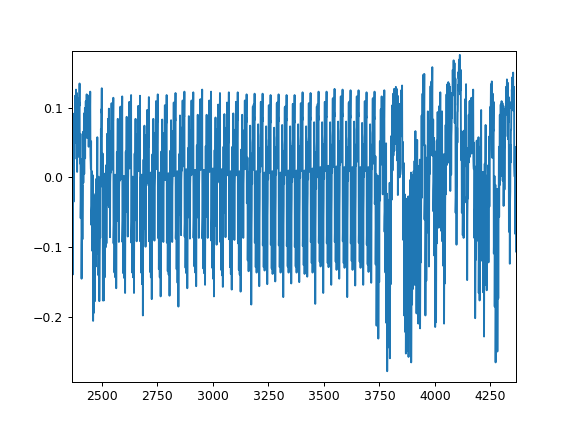

In [22]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(wave)
plt.show()

In [20]:
scope.adc.decimate = 1
scope.adc.offset = 15000*4

In [ ]:
#Capture Traces
# let's get them to do this
from tqdm import tnrange
import numpy as np
import time
N = 200  # Number of traces
for i in tnrange(N, desc='Capturing traces'):
    message = [0x00]
    target.read()
    
    key, text = ktp.next()
    message.extend(text)
    
    crc = bl_crc.bit_by_bit(text)
    message.append(crc >> 8)
    message.append(crc & 0xFF)

    scope.arm()

    target.write(message)
    
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')
    response = target.read()
    if ord(response[0]) != 0xA4:
        # Bad response, just skip
        print("Bad response: {:02X}".format(ord(response[0])))
        continue
    
    project.traces.append(cw.Trace(scope.get_last_trace(), text, "", key))

## Analysis

Now that we have our traces, we can go ahead and perform the attack. As described in the background theory, we'll have to do two attacks - one to get the 14th round key, and another (using the first result) to get the 13th round key. Then, we'll do some post-processing to finally get the 256 bit encryption key.

### 14th Round Key

We can attack the 14th round key with a standard, no-frills CPA attack (using the inverse sbox, since it's a decryption that we're breaking):

In [ ]:
import chipwhisperer as cw
import chipwhisperer.analyzer as cwa

leak_model = cwa.leakage_models.inverse_sbox_output

attack = cwa.cpa(project, leak_model)

With the setup done, we can actually preform the attack. Narrow the range of the attack if you want it to run faster.

In [ ]:
key = [0xea, 0x79, 0x79, 0x20, 0xc8, 0x71, 0x44, 0x7d, 0x46, 0x62, 0x5f, 0x51, 0x85, 0xc1, 0x3b, 0xcb]

cb = cwa.get_jupyter_callback(attack)
if PLATFORM == "CWLITEARM" or PLATFORM == "CW308_STM32F3":
    attack.point_range = [1400, 2600]
elif PLATFORM == "CWLITEXMEGA" or PLATFORM == "CW303":
    pass
attack_results = attack.run(cb)

In [ ]:
rec_key = []
for bnum in attack_results.find_maximums():
    rec_key.append(bnum[0][0])
    print("Best Guess = 0x{:02X}, Corr = {}".format(bnum[0][0], bnum[0][2]))

### 13th Round Key

Analyzer doesn't have a leakage model for the 13th round key built in, so we'll need to create our own.

The traces for the XMEGA version of the firmware become desynced around sample 7000. This is due to a non-constant AES implementation: the code does not always take the same amount of time to run for every input. (It's actually possible to do a timing attack on this AES implementation! We'll stick with our CPA attack for now.)

While this does open up a timing attack, it actually makes our AES attack a little harder, since we'll have to resync the traces. Luckily you already know how to resync the traces!

Remember, what you're recovering here isn't actually the 13th round key since there was a mix columns operation in that round. Instead, what we've recovered is:

```python
InvShiftRows(InvMixColumns(recv_key))
```

Undo these operations and you should arrive at the correct 13th round key!

### Getting the First Round Key

We've got our AES256 decryption key now, but we can't use that to encrypt the plaintext, only decrypt. We'll need to use those to calculate the first and second round keys, which we can then use to encrypt the plaintext. ChipWhisperer has a built in function for doing the key schedule calculation:

With that, we're ready to move onto breaking the rest of the bootloader (the IV and signature). Let's start off by doing a little recon. 